In [14]:
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
import ipyparallel as ipp
import numpy as np 
c = ipp.Client(profile='mpi')
print(c.ids)
view = c[:]
view.activate()


[0, 1, 2, 3, 4, 5]


# 1d arrays

In [6]:
%%px --block    

from mpi4py import MPI 
import numpy as np

rank = MPI.COMM_WORLD.Get_rank()
No_processes = MPI.COMM_WORLD.Get_size()
nx = 28*No_processes
X_local = np.empty(nx//No_processes,dtype=np.float64)
if rank == 0:
    X = np.linspace(0,10.0,nx)  
else:
    X = None

MPI.COMM_WORLD.Scatter(X, X_local)
f_local = np.sin(X_local)


In [7]:
X = view['X'][np.argsort(view['rank'])[0]]


In [11]:
X_from_local = np.hstack([view['X_local'][i] for i in np.argsort(view['rank'])])
f_from_local = np.hstack([view['f_local'][i] for i in np.argsort(view['rank'])])


In [22]:
np.all( X_from_local == X)

True

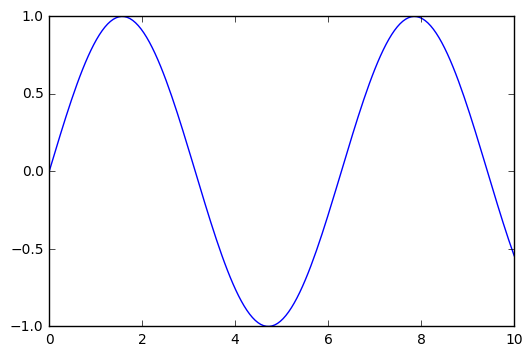

In [15]:
plt.plot(X_from_local,f_from_local)

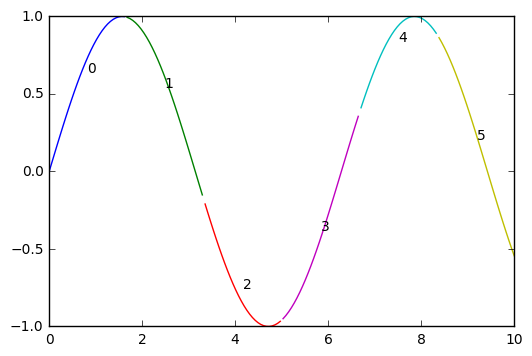

In [20]:
plt.clf()
for x,f,rank in zip(view['X_local'],view['f_local'],view['rank'] ):
    plt.plot(x,f)
    plt.text( np.average(x),np.average(f),"%d"%rank)                

In [21]:
view['rank']

[0, 1, 2, 4, 3, 5]

# 2d arrays

## Row major (C-like ordering)

In [7]:
%%px --block    

from mpi4py import MPI 
import numpy as np

rank = MPI.COMM_WORLD.Get_rank()
No_processes = MPI.COMM_WORLD.Get_size()
nx,ny = 16,3
X_local = np.empty((nx//No_processes,ny),dtype=np.int)
if rank == 0:
    X = np.random.randint(60,size=(nx,ny))  
else:
    X = None

MPI.COMM_WORLD.Scatter(X, X_local)


In [24]:
np.argsort(view['rank'])

array([2, 0, 3, 1])

In [8]:
X = view['X'][np.argsort(view['rank'])[0]]
X

array([[27, 12,  1],
       [ 3, 20, 55],
       [27, 22,  3],
       [14, 50,  9],
       [17,  5, 14],
       [16, 37,  1],
       [34,  4, 59],
       [47, 56, 43],
       [54, 32, 57],
       [52, 39, 34],
       [ 9, 45, 17],
       [ 7,  5, 24],
       [ 0, 43, 19],
       [18,  3, 47],
       [49, 31, 28],
       [39, 37, 49]])

In [9]:
X_from_local = np.vstack([view['X_local'][i] for i in np.argsort(view['rank'])])
X_from_local 

array([[27, 12,  1],
       [ 3, 20, 55],
       [27, 22,  3],
       [14, 50,  9],
       [17,  5, 14],
       [16, 37,  1],
       [34,  4, 59],
       [47, 56, 43],
       [54, 32, 57],
       [52, 39, 34],
       [ 9, 45, 17],
       [ 7,  5, 24],
       [ 0, 43, 19],
       [18,  3, 47],
       [49, 31, 28],
       [39, 37, 49]])

In [10]:
np.all(X_from_local  == X)

True

## Column major (Fortran-like ordering)

In [40]:
%%px --block    

from mpi4py import MPI 
import numpy as np

rank = MPI.COMM_WORLD.Get_rank()
No_processes = MPI.COMM_WORLD.Get_size()
nx,ny = 3,16
X_local = np.empty((nx,ny//No_processes),dtype=np.int,order='F')
if rank == 0:
    X = np.asfortranarray( np.random.randint(60,size=(nx,ny))  )
else:
    X = None

MPI.COMM_WORLD.Scatter(X, X_local)


In [41]:
X = view['X'][np.argsort(view['rank'])[0]]
X

array([[11, 28, 21, 58, 50, 29, 27, 42, 19, 29, 52, 25,  1, 54, 26, 36],
       [57, 38, 23, 54, 48, 41, 47, 17, 19, 22, 31,  7, 24,  4, 39, 18],
       [47, 29, 42, 48, 24,  6, 27, 47, 18, 30, 38, 18, 56, 28, 33,  5]])

In [42]:
view['X_local'][2]

array([[11, 28, 21, 58],
       [57, 38, 23, 54],
       [47, 29, 42, 48]])

In [45]:
X_from_local = np.hstack([view['X_local'][i] for i in np.argsort(view['rank'])])
X_from_local 

array([[11, 28, 21, 58, 50, 29, 27, 42, 19, 29, 52, 25,  1, 54, 26, 36],
       [57, 38, 23, 54, 48, 41, 47, 17, 19, 22, 31,  7, 24,  4, 39, 18],
       [47, 29, 42, 48, 24,  6, 27, 47, 18, 30, 38, 18, 56, 28, 33,  5]])

In [46]:
np.all(X_from_local  == X)

True

# notes

In [31]:
X_local = np.random.randint(55,size=(6,4))
X_local

array([[46, 19, 46, 54],
       [24, 34, 17, 26],
       [ 3,  8, 27, 14],
       [ 3, 23, 20, 41],
       [32,  5, 47, 53],
       [20, 20, 43,  3]])

In [32]:
L_bulk  = (1,slice(None))
L_ghost = (0,slice(None))
R_bulk  = (-2, slice(None))
R_ghost = (-1, slice(None))

In [38]:
X_local[R_ghost]

array([20, 20, 43,  3])

In [39]:
X_local[R_bulk]

array([32,  5, 47, 53])

In [40]:
X_local[L_ghost]

array([46, 19, 46, 54])

In [43]:
from mpi4py import MPI


MPI.COMM_WORLD.Gather?